#### Source from [Here](https://ynd.co/blog/tensorflow-vs-pytorch)

In [1]:
# for Pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning

# for tensorflow
import tensorflow as tf
from tensorflow import keras

# other usefull library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# create the transformer for put the data to the tensor
transforms = transforms.Compose([
    transforms.ToTensor()
])

# load the train data - if not exists download it
train_dataset_py = torchvision.datasets.FashionMNIST(root='./Fashion_MNIST/',
                                             train=True, 
                                             transform=transforms,
                                             download=True)

test_dataset_py = torchvision.datasets.FashionMNIST(root='./Fashion_MNIST/',
                                             train=False, 
                                             transform=transforms,
                                             download=True)

In [3]:
# Load the data set
fashion_mnist = keras.datasets.fashion_mnist

#split to test and train
(train_images_tf, train_labels_tf), (test_images_tf, test_labels_tf) = fashion_mnist.load_data()

In [4]:
train_images_tf = train_images_tf / 255.0
test_images_tf = test_images_tf / 255.0

In [5]:
def imshowPytorch(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def imshowTensorFlow(img):
    plt.imshow(img)

tensor(9)


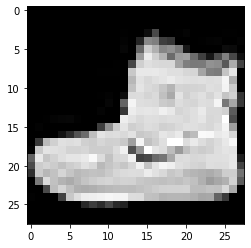

In [6]:
# create a data loader - I will use it for the training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_py,
                                           batch_size=32, 
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_py,
                                           batch_size=32, 
                                           shuffle=False, num_workers=2)
                                           
data_iter = iter(train_loader)
images, label = data_iter.next()
imshowPytorch(torchvision.utils.make_grid(images[0]))
print(label[0])

9


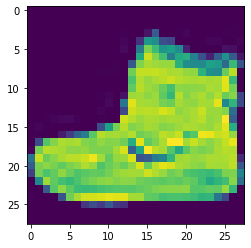

In [7]:
imshowTensorFlow(train_images_tf[0])

print(train_labels_tf[0])

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, num_of_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
modeltf = keras.Sequential([
    keras.layers.Conv2D(input_shape=(28,28,1), filters=16, kernel_size=5, strides=1, padding="same", activation=tf.nn.relu),
    keras.layers.BatchNormalization(), 
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, padding="same", activation=tf.nn.relu),
    keras.layers.BatchNormalization(), 
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [10]:
modelpy = NeuralNet(10)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modelpy.parameters())

modelpy

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [11]:
modeltf.compile(optimizer=keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
modeltf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [12]:
def count_modelParams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
print(count_modelParams(modelpy))

29034


In [14]:
%%time

modelpy.train()
for e in range(10):
    # define the loss value after the epoch
    losss = 0.0
    number_of_sub_epoch = 0
    
    # loop for every training batch (one epoch)
    for images, labels in train_loader:
        #create the output from the network
        out = modelpy(images)
        # count the loss function
        loss = criterion(out, labels)
        # in pytorch you have assign the zero for gradien in any sub epoch
        optim.zero_grad()
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        # add new value to the main loss
        losss += loss.item()
        number_of_sub_epoch += 1
    print("step {}: loss: {}".format(e, losss / number_of_sub_epoch))

step 0: loss: 0.38715100294152893
step 1: loss: 0.2805996476908525
step 2: loss: 0.24465357029040655
step 3: loss: 0.2210026885519425
step 4: loss: 0.20166135769983132
step 5: loss: 0.18459562652210396
step 6: loss: 0.16994346136103075
step 7: loss: 0.15696369028737148
step 8: loss: 0.145061860999465
step 9: loss: 0.13538551735704143
CPU times: user 19min 30s, sys: 37.2 s, total: 20min 7s
Wall time: 8min 1s


In [15]:
train_images_tf = train_images_tf.reshape(train_images_tf.shape[0], 
                                          train_images_tf.shape[1],
                                          train_images_tf.shape[2], 1)

In [14]:
%%time
modeltf.fit(train_images_tf, train_labels_tf, epochs=10, batch_size=32, max_queue_size=1)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 615us/sample - loss: 0.4046 - accuracy: 0.8584
Epoch 2/10
60000/60000 [==============================] - 36s 601us/sample - loss: 0.2856 - accuracy: 0.8984
Epoch 3/10
60000/60000 [==============================] - 36s 595us/sample - loss: 0.2495 - accuracy: 0.9098
Epoch 4/10
60000/60000 [==============================] - 38s 636us/sample - loss: 0.2240 - accuracy: 0.9179
Epoch 5/10
60000/60000 [==============================] - 37s 613us/sample - loss: 0.2036 - accuracy: 0.9260
Epoch 6/10
60000/60000 [==============================] - 37s 611us/sample - loss: 0.1880 - accuracy: 0.9307
Epoch 7/10
60000/60000 [==============================] - 36s 597us/sample - loss: 0.1724 - accuracy: 0.9370
Epoch 8/10
60000/60000 [==============================] - 36s 594us/sample - loss: 0.1616 - accuracy: 0.9403
Epoch 9/10
60000/60000 [==============================] - 37s 615us/sample - loss: 0.1483 - accuracy: 0.9

In [16]:
for images, labels in train_loader:
    out = modelpy(images)
    
    loss = criterion(out, labels)
    print(loss)
    print(loss.grad_fn)
    
    break

tensor(0.1075, grad_fn=<NllLossBackward>)


In [1]:
import torch
from torch.multiprocessing import Process, Pool, set_start_method
import numpy as np
import random

In [2]:
try:
    set_start_method('spawn')
except RuntimeError:
    print("Error")

In [20]:
conv2d = torch.nn.Conv2d(32, 32, 3, 1, 1)

inp = np.random.randn(2, 32, 128, 128)
inp = torch.Tensor(inp)

In [21]:
%timeit -n 100 -r 1 conv2d(inp)

8.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [15]:
import tensorflow as tf
import numpy as np

conv2d_tf = tf.keras.layers.Conv2D(32, 3, 1, 'same')

In [18]:
inp = np.random.randn(2, 128, 128, 32)

In [19]:
%timeit -n 100 -r 1 conv2d_tf(inp)

7.22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
